# Prophet
Meta(facebook)が公開した時系列予測のためのOSSライブラリ。Pythonでのインストール方法は[**Installation in Python**](https://facebook.github.io/prophet/docs/installation.html#python)を参照してください。基本的には `pip install prophet` を実行すればインストールできます。

In [1]:
# Google　Colaboratory で実行する場合はインストールする
if str(get_ipython()).startswith("<google.colab."):
    !pip install japanize_matplotlib
    !pip install prophet

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib
from prophet import Prophet

In [3]:
# グラフの表示パラメタ
sns.set(
    rc={
        "figure.figsize": (12, 4),
        "legend.fontsize": "large",
        "figure.titlesize": "large",
        "axes.titlesize": 20,
    }
)
japanize_matplotlib.japanize()

## 実験に使用するデータ
１年間のデータを用意します。偶数の月は数値が減少する傾向があります。また、週ごとに周期的な数値を取ります。
2020/1/1 ~ 2020/12/31 の期間のデータです。

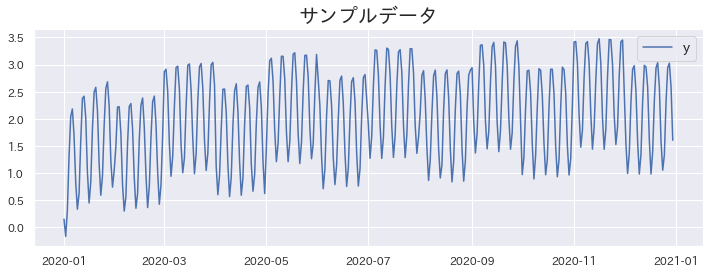

In [4]:
date = pd.date_range("2020-01-01", periods=365, freq="D")

# 予測対象
y = [
    np.cos(di.weekday())
    + di.month % 2 / 2
    + np.log(i + 1) / 3.0
    + np.random.rand() / 10
    for i, di in enumerate(date)
]

# トレンド成分
x = [18627 + i - 364 for i in range(365)]
trend_y = [np.log(i + 1) / 3.0 for i, di in enumerate(date)]
weekly_y = [np.cos(di.weekday()) for i, di in enumerate(date)]
seasonal_y = [di.month % 2 / 2 for i, di in enumerate(date)]
noise_y = [np.random.rand() / 10 for i in range(365)]

df = pd.DataFrame({"ds": date, "y": y})
df.index = date

# 実験に使用するデータ
plt.title("サンプルデータ")
sns.lineplot(data=df)
plt.show()

## 時系列データを構成する要素
「時系列データ」という言葉にはいろいろな種類のデータが含まれます。
ここでは、

- データはタイムスタンプと数値のみ
- タイムスタンプは全て欠損がなく等間隔(evenly spaced)に並んでいる

ようなデータを扱います。

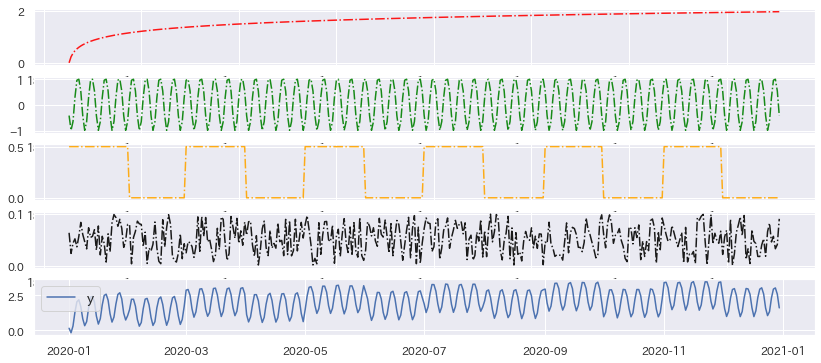

In [5]:
plt.figure(figsize=(14, 6))
plt.title("yを成分ごとに分解したもの")
plt.subplot(511)
plt.plot(x, trend_y, "-.", color="red", label="トレンド", alpha=0.9)
plt.subplot(512)
plt.plot(x, weekly_y, "-.", color="green", label="周期的な変動(週ごと)", alpha=0.9)
plt.subplot(513)
plt.plot(x, seasonal_y, "-.", color="orange", label="周期的な変動(月ごと)", alpha=0.9)
plt.subplot(514)
plt.plot(x, noise_y, "-.", color="k", label="ノイズ成分")
plt.subplot(515)
sns.lineplot(data=df)
plt.show()

## Prophetで2021年の1~3月を予測する
2020/1/1 ~ 2020/12/31 のデータを使って、さらに先の３ヶ月を予測してみます。
データは一年しかないので `yearly_seasonality=False`、週ごとに周期性が見られるので `daily_seasonality=True`を指定します。

In [6]:
def train_and_forecast_pf(
    data,
    periods=90,
    yearly_seasonality=False,
    weekly_seasonality=True,
    daily_seasonality=True,
):
    """prophetを訓練して予測をする

    Args:
        data (pandas.DataFrame): 時系列データ
        periods (int, optional): 予測する期間の長さ. Defaults to 90.
        yearly_seasonality (bool, optional): 年単位の季節成分があるかどうか. Defaults to False.
        weekly_seasonality (bool, optional): 週単位の季節成分があるかどうか. Defaults to True.
        daily_seasonality (bool, optional): 日単位の季節成分があるかどうか. Defaults to True.

    Returns:
        _type_: 予測モデル, 予測結果
    """
    assert "ds" in data.columns and "y" in data.columns, "入力するデータにはds, yの列が必要です。"
    # モデルを訓練
    m = Prophet(
        yearly_seasonality=yearly_seasonality,
        weekly_seasonality=weekly_seasonality,
        daily_seasonality=daily_seasonality,
    )
    m.fit(df)

    # 将来を予測
    future = m.make_future_dataframe(periods=periods)
    forecast = m.predict(future)
    return m, forecast

Initial log joint probability = -32.1541
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       772.276   5.98161e-05       56.7832           1           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     131        772.59    0.00128893       157.592   1.465e-05       0.001      217  LS failed, Hessian reset 
     181       772.678   3.78737e-05       49.0389   6.852e-07       0.001      326  LS failed, Hessian reset 
     199       772.681   1.42622e-06       43.2231      0.6929      0.6929      350   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     230       772.681   6.80165e-06       56.0478   7.185e-08       0.001      432  LS failed, Hessian reset 
     245       772.681   4.06967e-08       48.5475      0.1802      0.8285      454   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

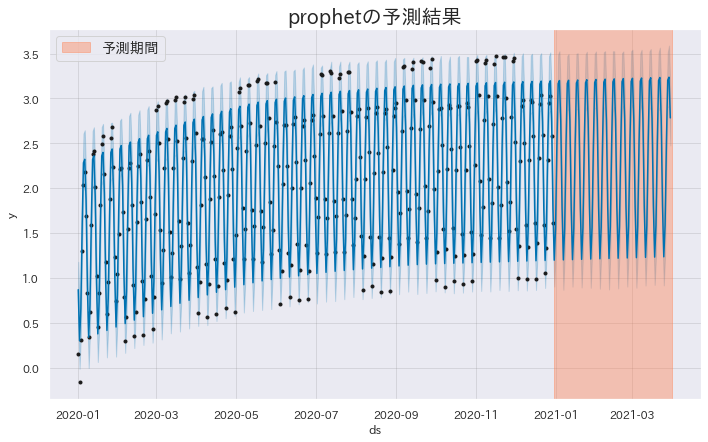

In [7]:
# 予測結果を確認する
periods = 90
m, forecast = train_and_forecast_pf(
    df,
    periods=periods,
    yearly_seasonality=False,
    weekly_seasonality=True,
    daily_seasonality=True,
)
fig = m.plot(forecast)
plt.title("prophetの予測結果")
plt.axvspan(18627, 18627 + periods, color="coral", alpha=0.4, label="予測期間")
plt.legend()
plt.show()

### 周期性の指定の影響
```{warning}
データに季節性が無いにも関わらず季節性の指定をすると、誤った予測になる可能性があります。
```

以下の例ではあえて**年の季節性がある**（`yearly_seasonality=True`）と指定しています。
年の周期を捉えるための項の影響で2022年の予測がやや不自然に増加していることがわかります。

Initial log joint probability = -32.1541
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1076.54   0.000445309       68.8033           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1078.13   0.000151685       92.7241           1           1      256   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     246       1078.14   1.78997e-06       84.0649    1.52e-08       0.001      353  LS failed, Hessian reset 
     261       1078.14   3.82403e-08       101.692      0.2973           1      372   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


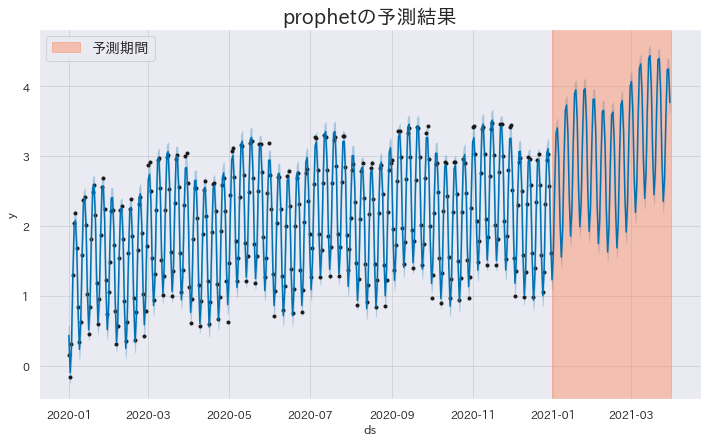

In [8]:
# 予測結果を確認する
periods = 90
m, forecast = train_and_forecast_pf(
    df,
    periods=periods,
    yearly_seasonality=True,
)
fig = m.plot(forecast)
plt.title("prophetの予測結果")
plt.axvspan(18627, 18627 + periods, color="coral", alpha=0.4, label="予測期間")
plt.legend()
plt.show()